<a href="https://colab.research.google.com/github/candiceevemiller/self-driving-cars/blob/main/speedestimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
path = 'gdrive/MyDrive/self-driving-cars/data/train/train.mp4'

vidObj = cv2.VideoCapture(path)

success = 1
video_frames = []
count = 0

while success:
    print(f'appending frame {count}')
    success, frame = vidObj.read()
    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video_frames.append(frame[150:350]) # crop hood and sky
        count += 1

Streaming output truncated to the last 5000 lines.
appending frame 15401
appending frame 15402
appending frame 15403
appending frame 15404
appending frame 15405
appending frame 15406
appending frame 15407
appending frame 15408
appending frame 15409
appending frame 15410
appending frame 15411
appending frame 15412
appending frame 15413
appending frame 15414
appending frame 15415
appending frame 15416
appending frame 15417
appending frame 15418
appending frame 15419
appending frame 15420
appending frame 15421
appending frame 15422
appending frame 15423
appending frame 15424
appending frame 15425
appending frame 15426
appending frame 15427
appending frame 15428
appending frame 15429
appending frame 15430
appending frame 15431
appending frame 15432
appending frame 15433
appending frame 15434
appending frame 15435
appending frame 15436
appending frame 15437
appending frame 15438
appending frame 15439
appending frame 15440
appending frame 15441
appending frame 15442
appending frame 15443
app

In [3]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [4]:
video_frames = np.array(video_frames)

In [5]:
GAMMA_FACTOR = 1.75

video_frames = adjust_gamma(video_frames, GAMMA_FACTOR)

In [6]:
frame_pairs = []
for index, frame in enumerate(video_frames):
    if index > 1:
        frame_pairs.append(np.dstack((video_frames[index-2], video_frames[index-1], frame)))
        # frame_pairs.append([video_frames[index-1], frame])
frame_pairs = np.array(frame_pairs)

In [7]:
frame_pairs.shape

(20398, 200, 640, 3)

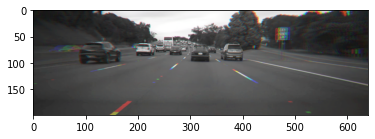

In [8]:
import matplotlib.pyplot as plt
plt.imshow(frame_pairs[1000])

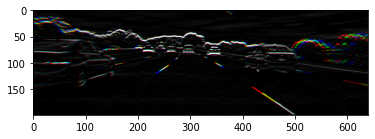

In [9]:
kernell = np.array([[1, 1, 1],
                    [0, 0, 0],
                    [-1, -1, -1]])
img = cv2.filter2D(src=frame_pairs[2000], ddepth = -1, kernel=kernell)
plt.imshow(img)

In [10]:
import tensorflow as tf

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x/255),
    tf.keras.layers.Conv2D(4, (3,3), padding='same', input_shape = (200,640,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(4, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1, activation='relu')
])

In [12]:
targets = np.fromfile('gdrive/MyDrive/self-driving-cars/data/train/train.txt', sep='\n')
targets = targets[2:]
targets.shape

(20398,)

In [13]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=root_mean_squared_error)

In [15]:
history = model.fit(frame_pairs, targets, batch_size=64, epochs=20,
                    validation_split=.3,)

Epoch 1/20
224/224 [==============================] - 14s 43ms/step - loss: 21.8208 - root_mean_squared_error: 3.4839 - val_loss: 87.6758 - val_root_mean_squared_error: 8.3766
Epoch 2/20
224/224 [==============================] - 8s 36ms/step - loss: 6.4636 - root_mean_squared_error: 1.9516 - val_loss: 62.7782 - val_root_mean_squared_error: 6.8945
Epoch 3/20
224/224 [==============================] - 8s 36ms/step - loss: 4.9087 - root_mean_squared_error: 1.6778 - val_loss: 70.7123 - val_root_mean_squared_error: 7.3360
Epoch 4/20
224/224 [==============================] - 8s 35ms/step - loss: 4.1287 - root_mean_squared_error: 1.5230 - val_loss: 64.7373 - val_root_mean_squared_error: 6.9491
Epoch 5/20
224/224 [==============================] - 8s 36ms/step - loss: 3.8360 - root_mean_squared_error: 1.4618 - val_loss: 66.9102 - val_root_mean_squared_error: 7.0606
Epoch 6/20
224/224 [==============================] - 8s 36ms/step - loss: 3.2440 - root_mean_squared_error: 1.3403 - val_loss: 